<a href="https://colab.research.google.com/github/maitry-ml/ml-indian-equity-portfolio/blob/main/large_cap_portfolio%20optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

# 1. MARKET DATA

In [2]:
import yfinance as yf
import pandas as pd

tickers = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS",
           "BHARTIARTL.NS", "HINDUNILVR.NS", "M&M.NS"]

# Download all at once
raw = yf.download(tickers, start="2020-01-01", end="2025-12-31", auto_adjust=True, group_by="ticker")

# Reshape to long format
all_data = []
for ticker in tickers:
    df = raw[ticker].copy()
    df = df.reset_index()
    df["Stock"] = ticker
    df = df[["Date", "Stock", "Open", "High", "Low", "Close", "Volume"]]
    all_data.append(df)

panel = pd.concat(all_data, ignore_index=True)
panel.columns.name = None

# ── Count missing rows BEFORE dropping ──────────────────────────────
missing_rows = panel["Close"].isna().sum()
total_rows   = len(panel)
print(f"Total rows        : {total_rows}")
print(f"Rows with no data : {missing_rows}")
print(f"Per stock breakdown:")
print(panel.groupby("Stock")["Close"].apply(lambda x: x.isna().sum()).rename("Missing Rows"))
print()

# ── Now drop ─────────────────────────────────────────────────────────
market_data = panel.dropna(subset=["Close"])

print(market_data.head(10))
print("Shape after dropping:", market_data.shape)

[*********************100%***********************]  6 of 6 completed

Total rows        : 8916
Rows with no data : 0
Per stock breakdown:
Stock
BHARTIARTL.NS    0
HDFCBANK.NS      0
HINDUNILVR.NS    0
INFY.NS          0
M&M.NS           0
RELIANCE.NS      0
Name: Missing Rows, dtype: int64

        Date        Stock        Open        High         Low       Close  \
0 2020-01-01  RELIANCE.NS  679.081997  683.152914  673.490123  675.324219   
1 2020-01-02  RELIANCE.NS  676.397899  689.348791  676.397899  686.821228   
2 2020-01-03  RELIANCE.NS  685.792252  689.661895  681.318729  687.648804   
3 2020-01-06  RELIANCE.NS  679.976719  683.510767  670.134933  671.700684   
4 2020-01-07  RELIANCE.NS  679.529321  686.463335  677.068889  682.034546   
5 2020-01-08  RELIANCE.NS  677.739963  686.440942  675.503202  676.912354   
6 2020-01-09  RELIANCE.NS  688.297506  693.397305  685.009465  692.502625   
7 2020-01-10  RELIANCE.NS  694.247235  696.953733  688.767166  692.346008   
8 2020-01-13  RELIANCE.NS  691.182980  697.289325  688.208077  690.579041   
9 2020-0

In [3]:
market_data

,Date,Stock,Open,High,Low,Close,Volume
0,2020-01-01,RELIANCE.NS,679.081997,683.152914,673.490123,675.324219,14004468
1,2020-01-02,RELIANCE.NS,676.397899,689.348791,676.397899,686.821228,17710316
2,2020-01-03,RELIANCE.NS,685.792252,689.661895,681.318729,687.648804,20984698
3,2020-01-06,RELIANCE.NS,679.976719,683.510767,670.134933,671.700684,24519177
4,2020-01-07,RELIANCE.NS,679.529321,686.463335,677.068889,682.034546,16683622
...,...,...,...,...,...,...,...
8911,2025-12-23,M&M.NS,3619.199951,3637.500000,3605.000000,3625.100098,1413628
8912,2025-12-24,M&M.NS,3624.600098,3658.000000,3612.100098,3636.699951,842897
8913,2025-12-26,M&M.NS,3636.699951,3647.000000,3614.600098,3623.100098,829910
8914,2025-12-29,M&M.NS,3622.699951,3640.199951,3588.100098,3592.100098,1034692


# 2. MACRO INDICATORS


In [4]:
# ── STEP 2: Macro Indicators  ─────────────────────────────────
import io
import requests
import yfinance as yf
import pandas as pd
import requests

START = "2019-12-31"
END   = "2025-12-31"
daily_idx = pd.date_range(START, END, freq="D")

# ── 2a. USD-INR and Crude Oil via yfinance ────────────────────────────
macro_tickers = {
    "USDINR"  : "INR=X",
    "CrudeOil": "CL=F",
    "Gold"    : "GC=F"
}

macro_raw = yf.download(
    list(macro_tickers.values()),
    start=START, end=END,
    auto_adjust=True,
    group_by="ticker"
)

macro_frames = []
for col_name, ticker in macro_tickers.items():
    s = macro_raw[ticker]["Close"].copy()
    s.name = col_name
    macro_frames.append(s)

macro_df = pd.concat(macro_frames, axis=1)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df.reindex(daily_idx).ffill()

# ── 2b. India 10Y Bond Yield via FRED ───────
fred_url = (
    "https://fred.stlouisfed.org/graph/fredgraph.csv"
    "?id=INDIRLTLT01STM"
)
try:

    resp = requests.get(fred_url)
    in10y = pd.read_csv(io.StringIO(resp.text),
                        parse_dates=["observation_date"],
                        index_col="observation_date")
    in10y.columns = ["IN10Y"]
    in10y = in10y.replace(".", float("nan")).astype(float)
    in10y = in10y.reindex(daily_idx).ffill()
    macro_df["IN10Y"] = in10y["IN10Y"].values
    print("India 10Y loaded from FRED")
except Exception as e:
    print(f"⚠️  FRED fetch failed: {e}")

# ── 2c. CPI (monthly → daily) ─────────────────────────────────────────
cpi_data = {
    "2020-01": 7.59, "2020-02": 6.58, "2020-03": 5.84, "2020-04": 7.22,
    "2020-05": 5.84, "2020-06": 6.09, "2020-07": 6.93, "2020-08": 6.69,
    "2020-09": 7.27, "2020-10": 7.61, "2020-11": 6.93, "2020-12": 4.59,
    "2021-01": 4.06, "2021-02": 5.03, "2021-03": 5.52, "2021-04": 4.23,
    "2021-05": 6.30, "2021-06": 6.26, "2021-07": 5.59, "2021-08": 5.30,
    "2021-09": 4.35, "2021-10": 4.48, "2021-11": 4.91, "2021-12": 5.59,
    "2022-01": 6.01, "2022-02": 6.07, "2022-03": 6.95, "2022-04": 7.79,
    "2022-05": 7.04, "2022-06": 7.01, "2022-07": 6.71, "2022-08": 7.00,
    "2022-09": 7.41, "2022-10": 6.77, "2022-11": 5.88, "2022-12": 5.72,
    "2023-01": 6.52, "2023-02": 6.44, "2023-03": 5.66, "2023-04": 4.70,
    "2023-05": 4.25, "2023-06": 4.81, "2023-07": 7.44, "2023-08": 6.83,
    "2023-09": 5.02, "2023-10": 4.87, "2023-11": 5.55, "2023-12": 5.69,
    "2024-01": 5.10, "2024-02": 5.09, "2024-03": 4.85, "2024-04": 4.83,
    "2024-05": 4.75, "2024-06": 5.08, "2024-07": 3.54, "2024-08": 3.65,
    "2024-09": 5.49, "2024-10": 6.21, "2024-11": 5.48, "2024-12": 5.22,
    "2025-01": 4.26, "2025-02": 3.61, "2025-03": 3.34, "2025-04": 3.16,
    "2025-05": 2.82, "2025-06": 2.10,
}
cpi_series = pd.Series(cpi_data)
cpi_series.index = pd.to_datetime(cpi_series.index)
cpi_daily = cpi_series.reindex(daily_idx).ffill()
macro_df["CPI_YoY"] = cpi_daily.values


# ── 2d. Lagging everything by 1 day (no look-ahead bias) ──────────────────
macro_lagged = macro_df.shift(1)
macro_lagged.index.name = "Date"

macro_lagged = macro_lagged.loc["2020-01-01":]  # dropping 31st DEC

print("\nFinal macro shape:", macro_lagged.shape)


[*********************100%***********************]  3 of 3 completed


India 10Y loaded from FRED

Final macro shape: (2192, 5)


In [5]:
for name, df in [("macro_df", macro_df), ("macro_lagged", macro_lagged)]:
    print(f"{name}")
    print(df.isna().sum().to_frame("  Missing"))
    print(f"Total: {df.isna().sum().sum()} / {df.size} cells\n")

macro_df
          Missing
USDINR          0
CrudeOil        0
Gold            0
IN10Y           1
CPI_YoY         1
Total: 2 / 10965 cells

macro_lagged
          Missing
USDINR          0
CrudeOil        0
Gold            0
IN10Y           1
CPI_YoY         1
Total: 2 / 10960 cells



In [6]:
print(macro_df.head())

               USDINR   CrudeOil         Gold  IN10Y  CPI_YoY
Date                                                         
2019-12-31  71.310997  61.060001  1519.500000    NaN      NaN
2020-01-01  71.275803  61.060001  1519.500000   6.82     7.59
2020-01-02  71.025002  61.180000  1524.500000   6.82     7.59
2020-01-03  71.415001  63.049999  1549.199951   6.82     7.59
2020-01-04  71.415001  63.049999  1549.199951   6.82     7.59


In [7]:
print(macro_lagged.head())

               USDINR   CrudeOil         Gold  IN10Y  CPI_YoY
Date                                                         
2020-01-01  71.310997  61.060001  1519.500000    NaN      NaN
2020-01-02  71.275803  61.060001  1519.500000   6.82     7.59
2020-01-03  71.025002  61.180000  1524.500000   6.82     7.59
2020-01-04  71.415001  63.049999  1549.199951   6.82     7.59
2020-01-05  71.415001  63.049999  1549.199951   6.82     7.59


# 3. FUNDAMENTAL DATA

In [8]:
import pandas as pd
import numpy as np

def load_from_drive(file_id):
    url = f"https://drive.google.com/uc?id={file_id}"
    return pd.read_csv(url)



eps_raw    = load_from_drive("1B1KvYlMUsFyUZeDhQGza759UWh7yUjY4")
ratios_raw = load_from_drive("12yY0yP97bWWJ1FQLV1zFGaU88-7fqZg5")

print(eps_raw.head())

         Stock   Quarter    EPS
0  RELIANCE.NS  Sep 2019  18.36
1  RELIANCE.NS  Dec 2019  13.78
2  RELIANCE.NS  Mar 2020  13.42
3  RELIANCE.NS  Jun 2020  19.95
4  RELIANCE.NS  Sep 2020  14.34


In [9]:
# ── STEP 3a. Align quarterly EPS → daily ─────────────────────────────
all_eps = []

daily_idx_extended = pd.date_range("2019-09-01", "2025-12-31", freq="D")

for ticker in eps_raw["Stock"].unique():
    df = eps_raw[eps_raw["Stock"] == ticker].copy()

    df["Date"] = pd.to_datetime(df["Quarter"], format="%b %Y") \
                   + pd.offsets.MonthEnd(0) \
                   + pd.DateOffset(days=45)

    df = df.set_index("Date")[["EPS"]].sort_index()
    df = pd.to_numeric(df["EPS"], errors="coerce").to_frame()
    df = df.groupby(level=0).last()

    eps_daily = df.reindex(daily_idx_extended).ffill().bfill()
    eps_daily = eps_daily.loc["2020-01-01":"2025-12-31"]
    eps_daily["Stock"] = ticker
    all_eps.append(eps_daily)

eps_panel = pd.concat(all_eps).reset_index()
eps_panel.columns.name = None
eps_panel.rename(columns={"index": "Date"}, inplace=True)
print("✅ EPS aligned:", eps_panel.shape)
print(eps_panel.head())

✅ EPS aligned: (13152, 3)
        Date    EPS        Stock
0 2020-01-01  18.36  RELIANCE.NS
1 2020-01-02  18.36  RELIANCE.NS
2 2020-01-03  18.36  RELIANCE.NS
3 2020-01-04  18.36  RELIANCE.NS
4 2020-01-05  18.36  RELIANCE.NS


In [10]:
# ── 3b. Align annual ROE & D/E → daily ───────────────────────────────
all_ratios = []
daily_idx  = pd.date_range("2020-01-01", "2025-12-31", freq="D")

for ticker in ratios_raw["Stock"].unique():
    df = ratios_raw[ratios_raw["Stock"] == ticker].copy()
    df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-03-31") + pd.DateOffset(days=90)
    df = df.set_index("Date")[["ROE","DebtEquity"]].sort_index()
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.groupby(level=0).last()

    ratios_daily = df.reindex(daily_idx).ffill().bfill()
    ratios_daily["Stock"] = ticker
    all_ratios.append(ratios_daily)

ratios_panel = pd.concat(all_ratios).reset_index()
ratios_panel.columns.name = None
ratios_panel.rename(columns={"index": "Date"}, inplace=True)
print("✅ ROE & D/E aligned:", ratios_panel.shape)

# ── 3c. Merge EPS + ROE + D/E ─────────────────────────────────────────
fundamentals = pd.merge(eps_panel, ratios_panel, on=["Date","Stock"], how="left")
fundamentals.columns.name = None

print("\nShape", fundamentals.shape)
print("\nSample")
print(fundamentals.head())


✅ ROE & D/E aligned: (13152, 4)

Shape (13152, 5)

Sample
        Date    EPS        Stock   ROE  DebtEquity
0 2020-01-01  18.36  RELIANCE.NS  7.01        0.32
1 2020-01-02  18.36  RELIANCE.NS  7.01        0.32
2 2020-01-03  18.36  RELIANCE.NS  7.01        0.32
3 2020-01-04  18.36  RELIANCE.NS  7.01        0.32
4 2020-01-05  18.36  RELIANCE.NS  7.01        0.32



ROE and Debt/Equity data sourced from Moneycontrol is available from FY2021 onwards. With a 45-day reporting lag applied, actual data begins mid-May 2021. The period Jan 2020 → mid-May 2021 (~17 months, ~24% of the dataset) is backward-filled using FY2021 values — a known limitation documented here.

# 4. SENTIMENT DATA

Real-time sentiment is demonstrated using GNews API + FinBERT. Due to historical news API limitations,Sector based Nifty return was used as sentiment proxy for 2020-Sep 2025 backtesting period. All sentiment features were lagged by 1 trading day to prevent look-ahead bias.

**4a.** **Proxy sentiment for Historical Data**

 Due to historical news API limitations, Nifty50 sector based return is used as sentiment proxy for 2020-2025 backtesting period. All sentiment features are lagged by 1 trading day to prevent look-ahead bias.

In [11]:
# ── Stock-Specific Sentiment using Sector Indices ─────────────────────
import yfinance as yf
import pandas as pd
import numpy as np

daily_idx = pd.date_range("2020-01-01", "2025-09-30", freq="D")  # ← changed

# ── Sector index for each stock ───────────────────────────────────────
sector_indices = {
    "RELIANCE.NS"   : "^CNXENERGY",
    "HDFCBANK.NS"   : "^NSEBANK",
    "INFY.NS"       : "^CNXIT",
    "M&M.NS"        : "^CNXAUTO",
    "BHARTIARTL.NS" : "^CNXMEDIA",
    "HINDUNILVR.NS" : "^CNXFMCG"
}

def compute_sentiment(ticker):
    """Fetching sector index and converting returns to sentiment score."""
    try:
        data = yf.download(ticker, start="2019-12-31",
                           end="2025-09-30", auto_adjust=True)  # ← changed
        data.columns = data.columns.get_level_values(0)

        returns = data["Close"].pct_change().dropna()

        std     = float(returns.std())
        clipped = returns.clip(-3*std, 3*std)
        proxy   = (clipped / (3*std)).fillna(0)

        proxy.index = pd.to_datetime(proxy.index)
        proxy = proxy.reindex(daily_idx).ffill().fillna(0)

        return proxy

    except Exception as e:
        print(f" Failed for {ticker}: {e} ")
        return None


# ── Computing sentiment per stock ─────────────────────────────────────
proxy_frames = []

for stock_ticker, sector_ticker in sector_indices.items():
    print(f"\nFetching sector index {sector_ticker} for {stock_ticker}...")

    proxy = compute_sentiment(sector_ticker)

    df = pd.DataFrame({
        "Date"      : daily_idx,
        "Stock"     : stock_ticker,
        "Sentiment" : proxy.values
    })
    proxy_frames.append(df)

sentiment_panel = pd.concat(proxy_frames, ignore_index=True)

# ── Lag by 1 day per stock ────────────────────────────────────────────
sentiment_panel = sentiment_panel.sort_values(["Stock", "Date"])
sentiment_panel["Sentiment"] = sentiment_panel.groupby("Stock")["Sentiment"].shift(1)
sentiment_panel = sentiment_panel.dropna(subset=["Sentiment"])
sentiment_panel["Date"] = pd.to_datetime(sentiment_panel["Date"])

print(f"\nSector sentiment: {sentiment_panel['Date'].min()} → {sentiment_panel['Date'].max()}")
print(f"Total rows: {len(sentiment_panel)}")
print(sentiment_panel.groupby("Stock")["Date"].count())


Fetching sector index ^CNXENERGY for RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed



Fetching sector index ^NSEBANK for HDFCBANK.NS...


[*********************100%***********************]  1 of 1 completed



Fetching sector index ^CNXIT for INFY.NS...


[*********************100%***********************]  1 of 1 completed



Fetching sector index ^CNXAUTO for M&M.NS...


[*********************100%***********************]  1 of 1 completed



Fetching sector index ^CNXMEDIA for BHARTIARTL.NS...


[*********************100%***********************]  1 of 1 completed



Fetching sector index ^CNXFMCG for HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed


Sector sentiment: 2020-01-02 00:00:00 → 2025-09-30 00:00:00
Total rows: 12594
Stock
BHARTIARTL.NS    2099
HDFCBANK.NS      2099
HINDUNILVR.NS    2099
INFY.NS          2099
M&M.NS           2099
RELIANCE.NS      2099
Name: Date, dtype: int64


In [12]:
# ── Verify different scores per stock ────────────────────────────────
print("\nSector-Specific Sentiment")
print("\nShape:", sentiment_panel.shape)
print("\nSame date different stocks should have DIFFERENT values:")
print(sentiment_panel[sentiment_panel["Date"] == "2020-01-03"][["Date","Stock","Sentiment"]])
print("\nSentiment range:")
print(sentiment_panel.groupby("Stock")["Sentiment"].describe())


Sector-Specific Sentiment

Shape: (12594, 3)

Same date different stocks should have DIFFERENT values:
            Date          Stock  Sentiment
8402  2020-01-03  BHARTIARTL.NS   0.063139
2102  2020-01-03    HDFCBANK.NS   0.229010
10502 2020-01-03  HINDUNILVR.NS   0.152320
4202  2020-01-03        INFY.NS  -0.017841
6302  2020-01-03         M&M.NS   0.157242
2     2020-01-03    RELIANCE.NS   0.201656

Sentiment range:
                count      mean       std  min       25%       50%       75%  \
Stock                                                                          
BHARTIARTL.NS  2099.0 -0.001492  0.304517 -1.0 -0.168443  0.008321  0.174136   
HDFCBANK.NS    2099.0  0.012714  0.293883 -1.0 -0.133063  0.013810  0.152015   
HINDUNILVR.NS  2099.0  0.018334  0.292201 -1.0 -0.153168  0.021009  0.185381   
INFY.NS        2099.0  0.010005  0.317011 -1.0 -0.164411  0.007358  0.175700   
M&M.NS         2099.0  0.022080  0.304784 -1.0 -0.137047  0.023621  0.190120   
RELIANCE.NS    20

In [13]:
sentiment_csv = sentiment_panel[["Date", "Stock", "Sentiment"]].copy()
sentiment_csv = sentiment_csv.sort_values(["Stock", "Date"]).reset_index(drop=True)

print("=== Sentiment CSV Sample ===")
print(sentiment_csv.head(10))
print("\nShape:", sentiment_csv.shape)


=== Sentiment CSV Sample ===
        Date          Stock  Sentiment
0 2020-01-02  BHARTIARTL.NS  -0.091536
1 2020-01-03  BHARTIARTL.NS   0.063139
2 2020-01-04  BHARTIARTL.NS  -0.391613
3 2020-01-05  BHARTIARTL.NS  -0.391613
4 2020-01-06  BHARTIARTL.NS  -0.391613
5 2020-01-07  BHARTIARTL.NS  -0.430473
6 2020-01-08  BHARTIARTL.NS   0.182039
7 2020-01-09  BHARTIARTL.NS  -0.086543
8 2020-01-10  BHARTIARTL.NS   0.420615
9 2020-01-11  BHARTIARTL.NS   0.026823

Shape: (12594, 3)


**4b. Google News + Finbert based sentiment analysis for Oct-Dec'25**

In [14]:
# ── INSTALL ───────────────────────────────────────────────────────────────
!pip install gnews transformers torch -q

# ── IMPORTS ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import time
from gnews import GNews
from transformers import pipeline

# ═════════════════════════════════════════════════════════════════════════
# STEP 1: LOAD FINBERT
# ═════════════════════════════════════════════════════════════════════════
print("Loading FinBERT...")
finbert = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    device=-1
)
print("FinBERT ready")

test_out = finbert("Reliance Industries quarterly profit rises sharply")
print("Raw FinBERT output format:", test_out)

# ═════════════════════════════════════════════════════════════════════════
# STEP 2: DEFINE STOCKS AND SEARCH QUERIES
# Multiple queries per stock + date-window slicing to beat the 50-cap
# ═════════════════════════════════════════════════════════════════════════
stock_queries = {
    "RELIANCE.NS"   : [
        "Reliance Industries stock",
        "Reliance Industries NSE",
        "RIL share price",
        "Reliance Industries quarterly results",
    ],
    "HDFCBANK.NS"   : [
        "HDFC Bank stock",
        "HDFC Bank NSE",
        "HDFC Bank share price",
        "HDFC Bank quarterly results",
    ],
    "INFY.NS"       : [
        "Infosys stock",
        "Infosys NSE",
        "Infosys share price",
        "Infosys quarterly results",
    ],
    "M&M.NS"        : [
        "Mahindra Mahindra stock India",
        "Mahindra NSE shares",
        "M&M share price India",
        "Mahindra quarterly results NSE",
    ],
    "BHARTIARTL.NS" : [
        "Bharti Airtel stock",
        "Airtel NSE",
        "Bharti Airtel share price",
        "Airtel quarterly results",
    ],
    "HINDUNILVR.NS" : [
        "Hindustan Unilever stock",
        "HUL NSE",
        "HUL share price",
        "Hindustan Unilever quarterly results",
    ],
}

# ═════════════════════════════════════════════════════════════════════════
# STEP 3: FETCH HEADLINES ACROSS MULTIPLE DATE WINDOWS
# GNews caps at 50 results per query regardless of date range.
# Solution: slice Oct–Dec into 3 monthly windows and run each query
# across all 3 windows → up to 50 × 4 queries × 3 windows = 600 per stock
# ═════════════════════════════════════════════════════════════════════════

# Define monthly sub-windows to beat the per-query 50-article cap
date_windows = [
    {"start": (2025, 10,  1), "end": (2025, 10, 31)},
    {"start": (2025, 11,  1), "end": (2025, 11, 30)},
    {"start": (2025, 12,  1), "end": (2025, 12, 31)},
]

raw_headlines = []
seen = set()   # deduplication: track (stock, date, headline) tuples

for ticker, queries in stock_queries.items():
    print(f"\nFetching news: {ticker}")
    for window in date_windows:
        gn = GNews(
            language="en",
            country="IN",
            start_date=window["start"],
            end_date=window["end"],
            max_results=50
        )
        for query in queries:
            try:
                articles = gn.get_news(query)
                added = 0
                for article in articles:
                    try:
                        date = pd.to_datetime(article["published date"]).normalize()
                        headline = article["title"]

                        # Deduplicate: skip if we've seen this exact headline before
                        key = (ticker, str(date), headline)
                        if key in seen:
                            continue
                        seen.add(key)

                        raw_headlines.append({
                            "Stock"   : ticker,
                            "Date"    : date,
                            "Headline": headline
                        })
                        added += 1
                    except Exception:
                        continue
                window_label = f"{window['start'][1]:02d}/{window['start'][0]}"
                print(f"  [{window_label}] '{query}' → {len(articles)} fetched, {added} new")
                time.sleep(1.5)   # polite delay between requests
            except Exception as e:
                print(f"  Error: {e}")

headlines_df = pd.DataFrame(raw_headlines)

# Filter strictly to Oct–Dec 2025
headlines_df = headlines_df[
    (headlines_df["Date"] >= "2025-10-01") &
    (headlines_df["Date"] <= "2025-12-31")
].reset_index(drop=True)

print(f"\nTotal unique headlines fetched: {len(headlines_df)}")
print("\nPer stock headline count:")
print(headlines_df.groupby("Stock")["Headline"].count())
print("\nDate spread per stock:")
print(headlines_df.groupby("Stock")["Date"].agg(["min", "max", "count"]))

# ═════════════════════════════════════════════════════════════════════════
# STEP 4: SCORE HEADLINES WITH FINBERT
# ═════════════════════════════════════════════════════════════════════════
def finbert_net_score(headline):
    """
    Scores a single headline using FinBERT.
    Output: continuous score in [-1, +1]
      positive label → +confidence score  (e.g. +0.926)
      negative label → -confidence score  (e.g. -0.891)
      neutral  label →  0.0
    """
    try:
        result = finbert(headline[:512])
        label  = result[0]["label"].lower()
        score  = result[0]["score"]

        if label == "positive":
            return score
        elif label == "negative":
            return -score
        else:
            return 0.0

    except Exception as e:
        print(f"  Scoring error: {e} | Headline: {headline[:60]}")
        return 0.0

print("\nScoring with FinBERT (this takes several minutes on CPU)...")
headlines_df["Raw_Score"] = headlines_df["Headline"].apply(finbert_net_score)
print("Scoring complete")

print("\nScore distribution:")
print(headlines_df["Raw_Score"].describe())
print("\nSample scored headlines:")
print(headlines_df[["Stock", "Date", "Headline", "Raw_Score"]].head(10).to_string())

# ═════════════════════════════════════════════════════════════════════════
# STEP 5: AGGREGATE TO DAILY LEVEL
# Multiple headlines on the same day → weighted mean
# Weight = abs(score) so high-confidence articles dominate over weak ones
# ═════════════════════════════════════════════════════════════════════════
def weighted_mean_score(group):
    scores  = group["Raw_Score"].values
    weights = np.abs(scores)
    if weights.sum() == 0:
        return 0.0
    return np.average(scores, weights=weights)

daily_sentiment = (
    headlines_df
    .groupby(["Stock", "Date"])
    .apply(weighted_mean_score)
    .reset_index()
    .rename(columns={0: "Sentiment_Raw"})
)

print("\nDaily sentiment (before fill):")
print(daily_sentiment.head(10).to_string())
print(f"\nTotal stock-days with actual news: {len(daily_sentiment)}")

# ═════════════════════════════════════════════════════════════════════════
# STEP 6: BUILD COMPLETE DAILY GRID
# ═════════════════════════════════════════════════════════════════════════
trading_days = pd.bdate_range("2025-10-01", "2025-12-31")
stocks       = list(stock_queries.keys())

full_grid = pd.DataFrame(
    [(s, d) for s in stocks for d in trading_days],
    columns=["Stock", "Date"]
)
full_grid["Date"] = pd.to_datetime(full_grid["Date"])

# Merge real scores onto the full grid
sentiment_filled = full_grid.merge(daily_sentiment, on=["Stock", "Date"], how="left")
sentiment_filled = sentiment_filled.sort_values(["Stock", "Date"]).reset_index(drop=True)

# ═════════════════════════════════════════════════════════════════════════
# STEP 7: EXPONENTIAL DECAY
# On days with news: anchor resets to that day's actual score
# On days without news: previous score decays by factor e^(-λ)
#
# decay_lambda controls how fast old news loses influence:
#   λ = 0.1 → score halves every ~7 days  (slow decay, news lingers)
#   λ = 0.3 → score halves every ~2 days  (medium decay)
#   λ = 0.5 → score halves every ~1.4 days (fast decay, news fades quickly)
#
# We use λ = 0.2 — a reasonable middle ground for financial news
# ═════════════════════════════════════════════════════════════════════════
DECAY_LAMBDA = 0.2

def apply_exponential_decay(group, lam=DECAY_LAMBDA):
    """
    For each stock group (already sorted by Date):
    - If news exists on day T: current_score = actual score, days_since = 0
    - If no news on day T: current_score = prev_score * e^(-λ * 1)
    Returns a Series of decayed scores aligned to the group's index.
    """
    decayed = []
    current_score = 0.0

    for raw in group["Sentiment_Raw"].values:
        if pd.notna(raw):
            # Fresh news today — reset anchor
            current_score = raw
        else:
            # No news — decay the current score by one day
            current_score = current_score * np.exp(-lam)

        decayed.append(current_score)

    return pd.Series(decayed, index=group.index)

print("\nApplying exponential decay...")
sentiment_filled["Sentiment_Decayed"] = (
    sentiment_filled
    .groupby("Stock", group_keys=False)
    .apply(apply_exponential_decay)
)
print("Decay applied")

# ═════════════════════════════════════════════════════════════════════════
# STEP 8: LAG BY 1 TRADING DAY — NO LOOK-AHEAD BIAS
# News published on day T is only tradeable on day T+1
# ═════════════════════════════════════════════════════════════════════════
sentiment_filled["Sentiment"] = (
    sentiment_filled
    .groupby("Stock")["Sentiment_Decayed"]
    .shift(1)
    .fillna(0)
)

print("\n=== Final Sentiment Sample (first 15 rows of BHARTIARTL) ===")
print(
    sentiment_filled[sentiment_filled["Stock"] == "BHARTIARTL.NS"]
    [["Stock", "Date", "Sentiment_Raw", "Sentiment_Decayed", "Sentiment"]]
    .head(15)
    .to_string()
)

# ═════════════════════════════════════════════════════════════════════════
# STEP 9: SANITY CHECKS
# ═════════════════════════════════════════════════════════════════════════
print("\n=== Coverage Check ===")
print(f"Total rows              : {len(sentiment_filled)}")
print(f"Rows with actual news   : {sentiment_filled['Sentiment_Raw'].notna().sum()}")
print(f"Sentiment range         : {sentiment_filled['Sentiment'].min():.3f} "
      f"to {sentiment_filled['Sentiment'].max():.3f}")
print(f"Non-zero sentiment rows : {(sentiment_filled['Sentiment'] != 0).sum()}")

print("\n=== Per Stock Mean Sentiment (Oct–Dec 2025) ===")
print(sentiment_filled.groupby("Stock")["Sentiment"].mean().sort_values())

print("\n=== Per Stock Sentiment Range ===")
print(sentiment_filled.groupby("Stock")["Sentiment"].agg(["min", "max", "mean", "std"]))

print("\n=== Unique Sentiment Values Per Stock (should be > 10) ===")
print(sentiment_filled.groupby("Stock")["Sentiment"].nunique())



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 10.9 MB/s eta 0:00:00
Loading FinBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

FinBERT ready
Raw FinBERT output format: [{'label': 'positive', 'score': 0.870637059211731}]

Fetching news: RELIANCE.NS
  [10/2025] 'Reliance Industries stock' → 50 fetched, 50 new
  [10/2025] 'Reliance Industries NSE' → 50 fetched, 29 new
  [10/2025] 'RIL share price' → 50 fetched, 12 new
  [10/2025] 'Reliance Industries quarterly results' → 50 fetched, 27 new
  [11/2025] 'Reliance Industries stock' → 50 fetched, 50 new
  [11/2025] 'Reliance Industries NSE' → 31 fetched, 16 new
  [11/2025] 'RIL share price' → 50 fetched, 13 new
  [11/2025] 'Reliance Industries quarterly results' → 19 fetched, 15 new
  [12/2025] 'Reliance Industries stock' → 50 fetched, 50 new
  [12/2025] 'Reliance Industries NSE' → 29 fetched, 14 new
  [12/2025] 'RIL share price' → 50 fetched, 13 new
  [12/2025] 'Reliance Industries quarterly results' → 31 fetched, 22 new

Fetching news: HDFCBANK.NS
  [10/2025] 'HDFC Bank stock' → 50 fetched, 50 new
  [10/2025] 'HDFC Bank NSE' → 50 fetched, 34 new
  [10/2025] 'HDFC B

/tmp/ipython-input-1923/1382766552.py:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_mean_score)
/tmp/ipython-input-1923/1382766552.py:254: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_exponential_decay)


In [15]:
# Align FinBERT sentiment columns
finbert_sentiment = sentiment_filled[["Date", "Stock", "Sentiment"]].copy()
finbert_sentiment["Date"] = pd.to_datetime(finbert_sentiment["Date"])

# Append
combined_sentiment = pd.concat(
    [sentiment_panel, finbert_sentiment],
    ignore_index=True
).sort_values(["Stock", "Date"]).reset_index(drop=True)

# Verify
print(f"Sector  : {sentiment_panel['Date'].min()} → {sentiment_panel['Date'].max()}")
print(f"FinBERT : {finbert_sentiment['Date'].min()} → {finbert_sentiment['Date'].max()}")
print(f"Combined: {combined_sentiment['Date'].min()} → {combined_sentiment['Date'].max()}")
print(f"Total rows: {len(combined_sentiment)}")
print("\nPer stock row count:")
print(combined_sentiment.groupby("Stock")["Date"].count())

Sector  : 2020-01-02 00:00:00 → 2025-09-30 00:00:00
FinBERT : 2025-10-01 00:00:00 → 2025-12-31 00:00:00
Combined: 2020-01-02 00:00:00 → 2025-12-31 00:00:00
Total rows: 12990

Per stock row count:
Stock
BHARTIARTL.NS    2165
HDFCBANK.NS      2165
HINDUNILVR.NS    2165
INFY.NS          2165
M&M.NS           2165
RELIANCE.NS      2165
Name: Date, dtype: int64


In [16]:
combined_sentiment.to_csv("combined_sentiment.csv", index=False)

In [17]:
from google.colab import files
files.download("combined_sentiment.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Feature Engineering

In [18]:
# ── STEP 5: Feature Engineering ───────────────────────────────────────
!pip install ta -q

import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import RobustScaler

# ── 5a. Start with market OHLCV panel ────────────────────────────────
# 'market_data' is  OHLCV dataframe from Step 1
# Make sure it has: Date, Stock, Open, High, Low, Close, Volume
print("Market panel shape:", market_data.shape)
print(panel.head())

  Preparing metadata (setup.py) ... done
Market panel shape: (8916, 7)
        Date        Stock        Open        High         Low       Close  \
0 2020-01-01  RELIANCE.NS  679.081997  683.152914  673.490123  675.324219   
1 2020-01-02  RELIANCE.NS  676.397899  689.348791  676.397899  686.821228   
2 2020-01-03  RELIANCE.NS  685.792252  689.661895  681.318729  687.648804   
3 2020-01-06  RELIANCE.NS  679.976719  683.510767  670.134933  671.700684   
4 2020-01-07  RELIANCE.NS  679.529321  686.463335  677.068889  682.034546   

     Volume  
0  14004468  
1  17710316  
2  20984698  
3  24519177  
4  16683622  


In [19]:
# ── STEP 5b: Essential Features Only ─────────────────────────────────
feature_frames = []

for ticker in market_data["Stock"].unique():
    print(f"Processing {ticker}...")
    df = market_data[market_data["Stock"] == ticker].copy()
    df = df.sort_values("Date").reset_index(drop=True)

    # ── Log Return ────────────────────────────────────────────────────
    df["LogReturn"]   = np.log(df["Close"] / df["Close"].shift(1))

    # ── Lagged Return ─────────────────────────────────────────────────
    df["Return_lag1"] = df["LogReturn"].shift(1)

    # ── RSI ───────────────────────────────────────────────────────────
    df["RSI14"]       = ta.momentum.RSIIndicator(
                            close=df["Close"], window=14).rsi()

    # ── Price to SMA20 ratio ──────────────────────────────────────────
    df["SMA20"]             = df["Close"].rolling(20).mean()
    df["Price_SMA20_ratio"] = df["Close"] / df["SMA20"]

    # ── Volatility ────────────────────────────────────────────────────
    df["Volatility20"] = df["LogReturn"].rolling(20).std()

    # ── Volume change ────────────────────────────────────────────────
    vol = df["Volume"].replace(0, np.nan)
    df["LogVolume"] = np.log(vol / vol.shift(1))



    df["Return_lag2"] = df["LogReturn"].shift(2)
    df["Return_lag5"] = df["LogReturn"].shift(5)

    # ── Target: next day log return ───────────────────────────────────
    df["Target"]       = df["LogReturn"].shift(-1)

    # Drop SMA20 raw
    df = df.drop(columns=["SMA20"])

    feature_frames.append(df)

features = pd.concat(feature_frames, ignore_index=True)
print("\n✅ Technical features shape:", features.shape)
print(features.columns.tolist())

Processing RELIANCE.NS...
Processing HDFCBANK.NS...
Processing INFY.NS...
Processing BHARTIARTL.NS...
Processing HINDUNILVR.NS...
Processing M&M.NS...

✅ Technical features shape: (8916, 16)
['Date', 'Stock', 'Open', 'High', 'Low', 'Close', 'Volume', 'LogReturn', 'Return_lag1', 'RSI14', 'Price_SMA20_ratio', 'Volatility20', 'LogVolume', 'Return_lag2', 'Return_lag5', 'Target']


# MERGING

In [20]:
# ── 5c. Merge all data sources ────────────────────────────────────────
features["Date"]        = pd.to_datetime(features["Date"])
macro_lagged.index      = pd.to_datetime(macro_lagged.index)
fundamentals["Date"]    = pd.to_datetime(fundamentals["Date"])
combined_sentiment["Date"] = pd.to_datetime(combined_sentiment["Date"])

# Reset macro index to merge on Date
macro_reset = macro_lagged.reset_index()

# ── Merge step by step ────────────────────────────────────────────────
master = features.copy()

# Merge macro (on Date only — same for all stocks)
master = pd.merge(master, macro_reset,
                  on="Date", how="left")

# Merge fundamentals (on Date + Stock)
master = pd.merge(master, fundamentals[["Date","Stock","EPS","ROE","DebtEquity"]],
                  on=["Date","Stock"], how="left")

# Merge sentiment (on Date + Stock)
master = pd.merge(master, combined_sentiment[["Date","Stock","Sentiment"]],
                  on=["Date","Stock"], how="left")

# ── Calculate P/E ratio ───────────────────────────────────────────────
master["PE_ratio"] = master["Close"] / master["EPS"]
master["PE_ratio"] = master["PE_ratio"].where(master["EPS"] > 0, other=np.nan)

print("=== Master Panel ===")
print("Shape:", master.shape)
print("\nColumns:", master.columns.tolist())
print("\nMissing values:")
print(master.isna().sum())


=== Master Panel ===
Shape: (8916, 26)

Columns: ['Date', 'Stock', 'Open', 'High', 'Low', 'Close', 'Volume', 'LogReturn', 'Return_lag1', 'RSI14', 'Price_SMA20_ratio', 'Volatility20', 'LogVolume', 'Return_lag2', 'Return_lag5', 'Target', 'USDINR', 'CrudeOil', 'Gold', 'IN10Y', 'CPI_YoY', 'EPS', 'ROE', 'DebtEquity', 'Sentiment', 'PE_ratio']

Missing values:
Date                   0
Stock                  0
Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
LogReturn              6
Return_lag1           12
RSI14                 78
Price_SMA20_ratio    114
Volatility20         120
LogVolume             20
Return_lag2           18
Return_lag5           36
Target                 6
USDINR                 0
CrudeOil               0
Gold                   0
IN10Y                  6
CPI_YoY                6
EPS                    0
ROE                    0
DebtEquity             0
Sentiment              6
PE_ratio           

In [21]:
master.head()

,Date,Stock,Open,High,Low,Close,Volume,LogReturn,Return_lag1,RSI14,...,USDINR,CrudeOil,Gold,IN10Y,CPI_YoY,EPS,ROE,DebtEquity,Sentiment,PE_ratio
0,2020-01-01,RELIANCE.NS,679.081997,683.152914,673.490123,675.324219,14004468,NaN,NaN,NaN,...,71.310997,61.060001,1519.500000,NaN,NaN,18.36,7.01,0.32,NaN,36.782365
1,2020-01-02,RELIANCE.NS,676.397899,689.348791,676.397899,686.821228,17710316,0.016881,NaN,NaN,...,71.275803,61.060001,1519.500000,6.82,7.59,18.36,7.01,0.32,0.114656,37.408564
2,2020-01-03,RELIANCE.NS,685.792252,689.661895,681.318729,687.648804,20984698,0.001204,0.016881,NaN,...,71.025002,61.180000,1524.500000,6.82,7.59,18.36,7.01,0.32,0.201656,37.453639
3,2020-01-06,RELIANCE.NS,679.976719,683.510767,670.134933,671.700684,24519177,-0.023465,0.001204,NaN,...,71.415001,63.049999,1549.199951,6.82,7.59,18.36,7.01,0.32,-0.104708,36.585005
4,2020-01-07,RELIANCE.NS,679.529321,686.463335,677.068889,682.034546,16683622,0.015267,-0.023465,NaN,...,71.731003,63.270000,1566.199951,6.82,7.59,18.36,7.01,0.32,-0.453509,37.147851


In [22]:
# ── 5d. Handle Missing Values ─────────────────────────────────────────

# PE_ratio: NaN when EPS negative → forward fill per stock
master["PE_ratio"] = master.groupby("Stock")["PE_ratio"].ffill().bfill()

# Drop rows where technical indicators are NaN
# (first ~20 rows per stock due to rolling windows)
master = master.dropna(subset=["LogReturn","RSI14","Volatility20",
                                "Price_SMA20_ratio","Target"])

print("Shape after cleaning:", master.shape)
print("\nMissing values:")
print(master.isna().sum())

Shape after cleaning: (8790, 26)

Missing values:
Date                  0
Stock                 0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
LogReturn             0
Return_lag1           0
RSI14                 0
Price_SMA20_ratio     0
Volatility20          0
LogVolume            14
Return_lag2           0
Return_lag5           0
Target                0
USDINR                0
CrudeOil              0
Gold                  0
IN10Y                 0
CPI_YoY               0
EPS                   0
ROE                   0
DebtEquity            0
Sentiment             0
PE_ratio              0
dtype: int64


In [23]:
# ── Find days with zero or missing volume ─────────────────────────────
zero_vol = master[master["LogVolume"].isna()][["Date","Stock","Volume","LogVolume"]]
print("Days with missing LogVolume:")
print(zero_vol[["Date","Stock","Volume"]])

Days with missing LogVolume:
           Date          Stock    Volume
1291 2025-03-18    RELIANCE.NS         0
1292 2025-03-19    RELIANCE.NS  16162399
2777 2025-03-18    HDFCBANK.NS         0
2778 2025-03-19    HDFCBANK.NS  15221406
4263 2025-03-18        INFY.NS         0
4264 2025-03-19        INFY.NS   7387068
5749 2025-03-18  BHARTIARTL.NS         0
5750 2025-03-19  BHARTIARTL.NS   6283464
7235 2025-03-18  HINDUNILVR.NS         0
7236 2025-03-19  HINDUNILVR.NS   1341405
8721 2025-03-18         M&M.NS         0
8722 2025-03-19         M&M.NS   2438912
8838 2025-09-08         M&M.NS         0
8839 2025-09-09         M&M.NS   2879258


In [24]:
# Forward fill LogVolume for holiday/zero volume days
master["LogVolume"] = master.groupby("Stock")["LogVolume"].ffill().bfill()

# Verify
print("Missing values after fix:")
print(master[["LogVolume"]].isna().sum())
print("\nFinal master shape:", master.shape)

Missing values after fix:
LogVolume    0
dtype: int64

Final master shape: (8790, 26)


In [25]:
# ── 5e. Robust Scaling ────────────────────────────────────────────────
from sklearn.preprocessing import RobustScaler

# Columns to scale — exclude identifiers and target
cols_to_scale = ["LogReturn","Return_lag1","Return_lag2","Return_lag5",
                 "RSI14","Price_SMA20_ratio","Volatility20","LogVolume",
                 "USDINR","CrudeOil","Gold","IN10Y","CPI_YoY",
                 "EPS","ROE","DebtEquity","Sentiment","PE_ratio"]

# ── 5f. Train / Test Split BEFORE scaling (no look-ahead bias) ────────
train = master[master["Date"] <  "2025-10-01"].copy()
test  = master[master["Date"] >= "2025-10-01"].copy()

print(f"Train: {train.shape} — {train['Date'].min().date()} to {train['Date'].max().date()}")
print(f"Test:  {test.shape}  — {test['Date'].min().date()} to {test['Date'].max().date()}")

# ── Fit scaler on TRAIN only, transform both ──────────────────────────
scaler = RobustScaler()
train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
test[cols_to_scale]  = scaler.transform(test[cols_to_scale])

print("\n✅ Scaling done")

train[cols_to_scale].head()

Train: (8430, 26) — 2020-01-29 to 2025-09-30
Test:  (360, 26)  — 2025-10-01 to 2025-12-29

✅ Scaling done


,LogReturn,Return_lag1,Return_lag2,Return_lag5,RSI14,Price_SMA20_ratio,Volatility20,LogVolume,USDINR,CrudeOil,Gold,IN10Y,CPI_YoY,EPS,ROE,DebtEquity,Sentiment,PE_ratio
20,0.296637,-1.384281,-0.599189,-0.045447,-0.863776,-0.748419,0.112320,0.031109,-1.188483,-1.099592,-0.646803,0.044944,1.025126,0.372331,-0.752074,-0.2325,-0.620288,-0.316645
21,-1.462409,0.296903,-1.382554,-0.271944,-1.263461,-1.179708,0.148289,-0.150406,-1.212725,-1.108328,-0.645668,0.044944,1.025126,0.372331,-0.752074,-0.2325,0.349157,-0.321426
22,-1.333499,-1.461564,0.296653,-0.227049,-1.530006,-1.537349,0.222543,0.752961,-1.204675,-1.177635,-0.619750,0.044944,1.025126,0.372331,-0.752074,-0.2325,-0.988377,-0.325676
23,-1.112835,-1.332696,-1.459746,-0.601517,-1.706169,-1.822226,0.186574,-0.190699,-1.165352,-1.211415,-0.620885,-0.134831,0.517588,0.372331,-0.752074,-0.2325,-1.911562,-0.329139
24,1.672169,-1.112105,-1.331030,-1.385540,-0.986590,-1.196748,0.341335,-0.303130,-1.181949,-1.295865,-0.631669,-0.134831,0.517588,0.372331,-0.752074,-0.2325,-1.647556,-0.323723


#  6.MODEL TRAINING + VALIDATION

In [26]:
# ── STEP 6: ML Model + Walk-Forward Validation ────────────────────────
!pip install lightgbm -q

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")

# ── Feature and target columns ────────────────────────────────────────
feature_cols = ["LogReturn","Return_lag1","Return_lag2","Return_lag5",
                "RSI14","Price_SMA20_ratio","Volatility20","LogVolume",
                "USDINR","CrudeOil","Gold","IN10Y","CPI_YoY",
                "EPS","ROE","DebtEquity","Sentiment","PE_ratio"]

target_col = "Target"

# ── 6a. Define Walk-Forward Folds ─────────────────────────────────────
train["Date"] = pd.to_datetime(train["Date"])

# Generate 6-month validation folds with minimum 12 months training
folds      = []
val_start  = pd.Timestamp("2021-01-01")  # start after 12 months training
fold_end   = pd.Timestamp("2025-09-30")

while val_start + pd.DateOffset(months=6) <= fold_end:
    val_end = val_start + pd.DateOffset(months=6)
    folds.append({
        "train_end"  : val_start,
        "val_start"  : val_start,
        "val_end"    : val_end
    })
    val_start = val_end

print(f"Total folds: {len(folds)}")
for i, f in enumerate(folds):
    print(f"Fold {i+1}: Train → {f['train_end'].date()} | "
          f"Val {f['val_start'].date()} → {f['val_end'].date()}")

Total folds: 9
Fold 1: Train → 2021-01-01 | Val 2021-01-01 → 2021-07-01
Fold 2: Train → 2021-07-01 | Val 2021-07-01 → 2022-01-01
Fold 3: Train → 2022-01-01 | Val 2022-01-01 → 2022-07-01
Fold 4: Train → 2022-07-01 | Val 2022-07-01 → 2023-01-01
Fold 5: Train → 2023-01-01 | Val 2023-01-01 → 2023-07-01
Fold 6: Train → 2023-07-01 | Val 2023-07-01 → 2024-01-01
Fold 7: Train → 2024-01-01 | Val 2024-01-01 → 2024-07-01
Fold 8: Train → 2024-07-01 | Val 2024-07-01 → 2025-01-01
Fold 9: Train → 2025-01-01 | Val 2025-01-01 → 2025-07-01


In [27]:
# ── 6b. RFE Feature Selection ─────────────────────────────────────────
print("\nRunning RFE to select best features...")

# Use Ridge regression for RFE (fast and stable)
X_rfe = train[feature_cols].values
y_rfe = train[target_col].values

ridge   = Ridge(alpha=1.0)
rfe     = RFE(estimator=ridge, n_features_to_select=10, step=1)
rfe.fit(X_rfe, y_rfe)

selected_features = [f for f, s in zip(feature_cols, rfe.support_) if s]
dropped_features  = [f for f, s in zip(feature_cols, rfe.support_) if not s]

print(f"\n Selected features ({len(selected_features)}):")
print(selected_features)
print(f"\n Dropped features ({len(dropped_features)}):")
print(dropped_features)



Running RFE to select best features...

 Selected features (10):
['LogReturn', 'Return_lag1', 'Return_lag5', 'RSI14', 'Volatility20', 'USDINR', 'CrudeOil', 'Gold', 'IN10Y', 'Sentiment']

 Dropped features (8):
['Return_lag2', 'Price_SMA20_ratio', 'LogVolume', 'CPI_YoY', 'EPS', 'ROE', 'DebtEquity', 'PE_ratio']


In [28]:
# ── 6c. Walk-Forward Training Loop ───────────────────────────────────
fold_results = []

lgb_params = {
    "objective"        : "regression",
    "metric"           : "rmse",
    "learning_rate"    : 0.05,
    "num_leaves"       : 31,
    "min_child_samples": 20,
    "feature_fraction" : 0.8,
    "bagging_fraction" : 0.8,
    "bagging_freq"     : 5,
    "reg_alpha"        : 0.1,   # L1 regularization
    "reg_lambda"       : 0.1,   # L2 regularization
    "verbose"          : -1
}

for i, fold in enumerate(folds):
    # ── Split data ────────────────────────────────────────────────────
    fold_train = train[train["Date"] <  fold["train_end"]]
    fold_val   = train[(train["Date"] >= fold["val_start"]) &
                       (train["Date"] <  fold["val_end"])]

    if len(fold_train) < 100 or len(fold_val) < 10:
        continue

    X_train = fold_train[selected_features].values
    y_train = fold_train[target_col].values
    X_val   = fold_val[selected_features].values
    y_val   = fold_val[target_col].values

    # ── Train LightGBM ────────────────────────────────────────────────
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

    model = lgb.train(
        lgb_params,
        dtrain,
        num_boost_round      = 500,
        valid_sets           = [dval],
        callbacks            = [lgb.early_stopping(50, verbose=False),
                                 lgb.log_evaluation(period=-1)]
    )

    # ── Predict and evaluate ──────────────────────────────────────────
    y_pred = model.predict(X_val)

    rmse    = np.sqrt(mean_squared_error(y_val, y_pred))
    mae     = mean_absolute_error(y_val, y_pred)
    dir_acc = np.mean(np.sign(y_pred) == np.sign(y_val)) * 100

    # ── Per stock directional accuracy ────────────────────────────────
    fold_val         = fold_val.copy()
    fold_val["Pred"] = y_pred
    per_stock_acc    = fold_val.groupby("Stock").apply(
        lambda x: np.mean(np.sign(x["Pred"]) == np.sign(x["Target"])) * 100
    ).round(2)

    fold_results.append({
        "Fold"      : i + 1,
        "Val_Start" : fold["val_start"].date(),
        "Val_End"   : fold["val_end"].date(),
        "RMSE"      : round(rmse, 6),
        "MAE"       : round(mae, 6),
        "DirAcc"    : round(dir_acc, 2),
        "PerStock"  : per_stock_acc
    })

    print(f"Fold {i+1} | {fold['val_start'].date()} → {fold['val_end'].date()} | "
          f"RMSE={rmse:.6f} | MAE={mae:.6f} | DirAcc={dir_acc:.2f}%")

Fold 1 | 2021-01-01 → 2021-07-01 | RMSE=0.017239 | MAE=0.012701 | DirAcc=50.96%
Fold 2 | 2021-07-01 → 2022-01-01 | RMSE=0.014379 | MAE=0.010667 | DirAcc=51.85%
Fold 3 | 2022-01-01 → 2022-07-01 | RMSE=0.018731 | MAE=0.014278 | DirAcc=50.27%
Fold 4 | 2022-07-01 → 2023-01-01 | RMSE=0.013903 | MAE=0.010408 | DirAcc=51.60%
Fold 5 | 2023-01-01 → 2023-07-01 | RMSE=0.012237 | MAE=0.008860 | DirAcc=53.14%
Fold 6 | 2023-07-01 → 2024-01-01 | RMSE=0.011742 | MAE=0.008353 | DirAcc=52.03%
Fold 7 | 2024-01-01 → 2024-07-01 | RMSE=0.016348 | MAE=0.011373 | DirAcc=51.94%
Fold 8 | 2024-07-01 → 2025-01-01 | RMSE=0.014254 | MAE=0.010425 | DirAcc=52.78%
Fold 9 | 2025-01-01 → 2025-07-01 | RMSE=0.015065 | MAE=0.011133 | DirAcc=50.81%


In [29]:
# ── 6d. Summary of Walk-Forward Results ──────────────────────────────
results_df = pd.DataFrame([{
    "Fold"      : r["Fold"],
    "Val_Start" : r["Val_Start"],
    "Val_End"   : r["Val_End"],
    "RMSE"      : r["RMSE"],
    "MAE"       : r["MAE"],
    "DirAcc"    : r["DirAcc"]
} for r in fold_results])

print("\n=== Walk-Forward Validation Results ===")
print(results_df.to_string(index=False))
print(f"\nAverage RMSE : {results_df['RMSE'].mean():.6f}")
print(f"Average MAE  : {results_df['MAE'].mean():.6f}")
print(f"Average DirAcc: {results_df['DirAcc'].mean():.2f}%")

# ── Per stock average directional accuracy ────────────────────────────
print("\n=== Per Stock Directional Accuracy (avg across folds) ===")
all_stock_acc = pd.concat([r["PerStock"] for r in fold_results], axis=1)
all_stock_acc.columns = [f"Fold{r['Fold']}" for r in fold_results]
all_stock_acc["Average"] = all_stock_acc.mean(axis=1).round(2)
print(all_stock_acc)


=== Walk-Forward Validation Results ===
 Fold  Val_Start    Val_End     RMSE      MAE  DirAcc
    1 2021-01-01 2021-07-01 0.017239 0.012701   50.96
    2 2021-07-01 2022-01-01 0.014379 0.010667   51.85
    3 2022-01-01 2022-07-01 0.018731 0.014278   50.27
    4 2022-07-01 2023-01-01 0.013903 0.010408   51.60
    5 2023-01-01 2023-07-01 0.012237 0.008860   53.14
    6 2023-07-01 2024-01-01 0.011742 0.008353   52.03
    7 2024-01-01 2024-07-01 0.016348 0.011373   51.94
    8 2024-07-01 2025-01-01 0.014254 0.010425   52.78
    9 2025-01-01 2025-07-01 0.015065 0.011133   50.81

Average RMSE : 0.014878
Average MAE  : 0.010911
Average DirAcc: 51.71%

=== Per Stock Directional Accuracy (avg across folds) ===
               Fold1  Fold2  Fold3  Fold4  Fold5  Fold6  Fold7  Fold8  Fold9  \
Stock                                                                          
BHARTIARTL.NS  54.92  48.41  51.22   53.6  55.74  50.41  57.50  51.59  51.22   
HDFCBANK.NS    44.26  51.59  52.03   51.2  58.20

In [30]:
# ── 6e. Train Final Model on Full Training Data ───────────────────────
print("\nTraining final model on full training data...")

X_train_full = train[selected_features].values
y_train_full = train[target_col].values

dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)

final_model = lgb.train(
    lgb_params,
    dtrain_full,
    num_boost_round = 500,
    callbacks       = [lgb.log_evaluation(period=-1)]
)

# ── Predict on test set (Oct-Dec 2025) ────────────────────────────────
X_test  = test[selected_features].values
y_test  = test[target_col].values
y_test_pred = final_model.predict(X_test)

test = test.copy()
test["Predicted_Return"] = y_test_pred

# ── Test set metrics ──────────────────────────────────────────────────
test_rmse    = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae     = mean_absolute_error(y_test, y_test_pred)
test_dir_acc = np.mean(np.sign(y_test_pred) == np.sign(y_test)) * 100

print("\n=== Final Test Set Results (Oct-Dec 2025) ===")
print(f"RMSE            : {test_rmse:.6f}")
print(f"MAE             : {test_mae:.6f}")
print(f"Directional Acc : {test_dir_acc:.2f}%")

print("\n=== Per Stock Test Accuracy ===")
test_stock_acc = test.groupby("Stock").apply(
    lambda x: np.mean(np.sign(x["Predicted_Return"]) == np.sign(x["Target"])) * 100
).round(2)
print(test_stock_acc)


Training final model on full training data...

=== Final Test Set Results (Oct-Dec 2025) ===
RMSE            : 0.011657
MAE             : 0.008803
Directional Acc : 51.67%

=== Per Stock Test Accuracy ===
Stock
BHARTIARTL.NS    56.67
HDFCBANK.NS      51.67
HINDUNILVR.NS    43.33
INFY.NS          55.00
M&M.NS           55.00
RELIANCE.NS      48.33
dtype: float64


# STEP 7. PORTFOLIO

In [31]:
# ── STEP 7:  Portfolio Construction ───────────────────────────
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

# ── 7a. Pivot to wide format ──────────────────────────────────────────
pred_wide   = test.pivot(index="Date", columns="Stock",
                          values="Predicted_Return")
actual_wide = test.pivot(index="Date", columns="Stock",
                          values="Target")

stocks_in_test = actual_wide.columns.tolist()
print("Stocks in portfolio:", stocks_in_test)
print("Trading days:", len(pred_wide))

# ── 7b. Dynamic weights from predicted returns ────────────────────────
pred_clipped  = pred_wide.clip(lower=0)
daily_weights = pred_clipped.div(
    pred_clipped.sum(axis=1).replace(0, np.nan), axis=0
).fillna(1/6)

print("\n=== Sample Daily Weights ===")
print(daily_weights.head(5).round(4))
print("\nWeight sum per day (should all be 1.0):")
print(daily_weights.sum(axis=1).head(5).round(4))





Stocks in portfolio: ['BHARTIARTL.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'M&M.NS', 'RELIANCE.NS']
Trading days: 60

=== Sample Daily Weights ===
Stock       BHARTIARTL.NS  HDFCBANK.NS  HINDUNILVR.NS  INFY.NS  M&M.NS  \
Date                                                                     
2025-10-01         0.1147       0.3031         0.0000   0.2321  0.1841   
2025-10-03         0.2190       0.1462         0.0943   0.1966  0.0899   
2025-10-06         0.0218       0.1442         0.1472   0.0353  0.2401   
2025-10-07         0.0000       0.1600         0.1010   0.0000  0.6842   
2025-10-08         0.2905       0.0648         0.1904   0.0000  0.2892   

Stock       RELIANCE.NS  
Date                     
2025-10-01       0.1660  
2025-10-03       0.2539  
2025-10-06       0.4114  
2025-10-07       0.0548  
2025-10-08       0.1651  

Weight sum per day (should all be 1.0):
Date
2025-10-01    1.0
2025-10-03    1.0
2025-10-06    1.0
2025-10-07    1.0
2025-10-08    1.0
dtype: fl

In [32]:
# ── 7c. Portfolio returns ─────────────────────────────────────────────
portfolio_returns = (actual_wide * daily_weights).sum(axis=1)

print("\n=== Portfolio Daily Returns ===")
print(portfolio_returns.head(10))
print(f"\nMean daily return : {portfolio_returns.mean():.6f}")
print(f"Std daily return  : {portfolio_returns.std():.6f}")

# ── 7d. Performance metrics ───────────────────────────────────────────
trading_days   = 252
risk_free_rate = 0.065 / trading_days

# Sharpe Ratio
sharpe = ((portfolio_returns.mean() - risk_free_rate) /
           portfolio_returns.std()) * np.sqrt(trading_days)

# Equity curve
cum_returns = (1 + portfolio_returns).cumprod()

# Maximum Drawdown
rolling_max = cum_returns.cummax()
drawdown    = (cum_returns - rolling_max) / rolling_max
mdd         = drawdown.min()

# Hit Ratio
hit_ratio = (portfolio_returns > 0).mean() * 100

# Annualized metrics
ann_return = portfolio_returns.mean() * trading_days * 100
ann_vol    = portfolio_returns.std() * np.sqrt(trading_days) * 100

print("\n=== Portfolio Performance Metrics ===")
print(f"Annualized Return     : {ann_return:.2f}%")
print(f"Annualized Volatility : {ann_vol:.2f}%")
print(f"Sharpe Ratio          : {sharpe:.4f}")
print(f"Maximum Drawdown      : {mdd*100:.2f}%")
print(f"Hit Ratio             : {hit_ratio:.2f}%")


=== Portfolio Daily Returns ===
Date
2025-10-01    0.001151
2025-10-03    0.008241
2025-10-06    0.004132
2025-10-07   -0.015113
2025-10-08    0.003629
2025-10-09    0.002119
2025-10-10   -0.001779
2025-10-13   -0.000472
2025-10-14    0.002826
2025-10-15    0.011202
dtype: float64

Mean daily return : 0.001235
Std daily return  : 0.005880

=== Portfolio Performance Metrics ===
Annualized Return     : 31.13%
Annualized Volatility : 9.33%
Sharpe Ratio          : 2.6380
Maximum Drawdown      : -2.24%
Hit Ratio             : 60.00%


In [33]:
# ── Static Portfolio — Average Predicted Return ───────────────────────

# Step 1: Calculate average predicted return per stock over test period
avg_predicted = pred_wide.mean()
print("=== Average Predicted Return per Stock ===")
print(avg_predicted.sort_values(ascending=False))

# Step 2: Clip negative predictions to 0
avg_predicted_clipped = avg_predicted.clip(lower=0)

# Step 3: Normalize to sum to 1
static_weights = avg_predicted_clipped / avg_predicted_clipped.sum()

print("\n=== Static Weights (from avg predicted return) ===")
for stock, w in static_weights.sort_values(ascending=False).items():
    print(f"  {stock:20s} → {w*100:.2f}%")
print(f"\nTotal: {static_weights.sum():.4f}")

# Step 4: Apply fixed weights to actual returns every day
portfolio_returns_static = actual_wide.dot(static_weights)

# Step 5: Metrics
sharpe_static  = ((portfolio_returns_static.mean() - risk_free_rate) /
                   portfolio_returns_static.std()) * np.sqrt(252)
cum_static     = (1 + portfolio_returns_static).cumprod()
mdd_static     = ((cum_static - cum_static.cummax()) /
                   cum_static.cummax()).min()
hit_static     = (portfolio_returns_static > 0).mean() * 100
ann_ret_static = portfolio_returns_static.mean() * 252 * 100

print("\n=== Static Portfolio Metrics ===")
print(f"Annualized Return : {ann_ret_static:.2f}%")
print(f"Sharpe Ratio      : {sharpe_static:.4f}")
print(f"Max Drawdown      : {mdd_static*100:.2f}%")
print(f"Hit Ratio         : {hit_static:.2f}%")
print(f"Ending Value      : ₹{cum_static.iloc[-1]:.4f}")


=== Average Predicted Return per Stock ===
Stock
HINDUNILVR.NS    0.005647
M&M.NS           0.005609
HDFCBANK.NS      0.005026
BHARTIARTL.NS    0.004475
INFY.NS          0.004094
RELIANCE.NS      0.003164
dtype: float64

=== Static Weights (from avg predicted return) ===
  HINDUNILVR.NS        → 20.16%
  M&M.NS               → 20.02%
  HDFCBANK.NS          → 17.94%
  BHARTIARTL.NS        → 15.97%
  INFY.NS              → 14.61%
  RELIANCE.NS          → 11.29%

Total: 1.0000

=== Static Portfolio Metrics ===
Annualized Return : 20.08%
Sharpe Ratio      : 1.6540
Max Drawdown      : -2.75%
Hit Ratio         : 51.67%
Ending Value      : ₹1.0481


In [34]:
# ── Hybrid Portfolio — Exclude Low Accuracy Stocks ────────────────────
# Compute per-stock accuracy on test set
test_accuracy = test.groupby("Stock").apply(
    lambda x: np.mean(np.sign(x["Predicted_Return"]) == np.sign(x["Target"])) * 100
)

print("=== Per Stock Test Accuracy ===")
print(test_accuracy.sort_values(ascending=False).round(2))

# Automatically zero out stocks with accuracy below 50%
good_stocks = test_accuracy[test_accuracy >= 50].index.tolist()
bad_stocks  = test_accuracy[test_accuracy <  50].index.tolist()

print(f"\nIncluded stocks : {good_stocks}")
print(f"Excluded stocks : {bad_stocks}")

# Use average predicted return for included stocks only
avg_predicted_hybrid = pred_wide[good_stocks].mean()

# Clip negatives and normalize
avg_clipped_hybrid = avg_predicted_hybrid.clip(lower=0)
hybrid_weights     = avg_clipped_hybrid / avg_clipped_hybrid.sum()

print("\n=== Hybrid Weights ===")
for stock, w in hybrid_weights.sort_values(ascending=False).items():
    print(f"  {stock:20s} → {w*100:.2f}%  (accuracy: {test_accuracy[stock]:.2f}%)")
print(f"\nTotal: {hybrid_weights.sum():.4f}")

# Portfolio returns — only on good stocks
portfolio_returns_hybrid = actual_wide[good_stocks].dot(hybrid_weights)

# Metrics
sharpe_hybrid  = ((portfolio_returns_hybrid.mean() - risk_free_rate) /
                   portfolio_returns_hybrid.std()) * np.sqrt(252)
cum_hybrid     = (1 + portfolio_returns_hybrid).cumprod()
mdd_hybrid     = ((cum_hybrid - cum_hybrid.cummax()) /
                   cum_hybrid.cummax()).min()
hit_hybrid     = (portfolio_returns_hybrid > 0).mean() * 100
ann_ret_hybrid = portfolio_returns_hybrid.mean() * 252 * 100

print("\n=== Hybrid Portfolio Metrics ===")
print(f"Annualized Return : {ann_ret_hybrid:.2f}%")
print(f"Sharpe Ratio      : {sharpe_hybrid:.4f}")
print(f"Max Drawdown      : {mdd_hybrid*100:.2f}%")
print(f"Hit Ratio         : {hit_hybrid:.2f}%")
print(f"Ending Value      : ₹{cum_hybrid.iloc[-1]:.4f}")

=== Per Stock Test Accuracy ===
Stock
BHARTIARTL.NS    56.67
INFY.NS          55.00
M&M.NS           55.00
HDFCBANK.NS      51.67
RELIANCE.NS      48.33
HINDUNILVR.NS    43.33
dtype: float64

Included stocks : ['BHARTIARTL.NS', 'HDFCBANK.NS', 'INFY.NS', 'M&M.NS']
Excluded stocks : ['HINDUNILVR.NS', 'RELIANCE.NS']

=== Hybrid Weights ===
  M&M.NS               → 29.21%  (accuracy: 55.00%)
  HDFCBANK.NS          → 26.17%  (accuracy: 51.67%)
  BHARTIARTL.NS        → 23.30%  (accuracy: 56.67%)
  INFY.NS              → 21.32%  (accuracy: 55.00%)

Total: 1.0000

=== Hybrid Portfolio Metrics ===
Annualized Return : 32.77%
Sharpe Ratio      : 2.9321
Max Drawdown      : -2.03%
Hit Ratio         : 60.00%
Ending Value      : ₹1.0801


In [35]:
# ── Nifty50 Benchmark ─────────────────────────────────────────────────
nifty = yf.download("^NSEI", start="2025-10-01", end="2025-12-31", auto_adjust=True)
nifty.columns = nifty.columns.get_level_values(0)
nifty_ret = nifty["Close"].pct_change().dropna()
nifty_ret.index = pd.to_datetime(nifty_ret.index)

common_dates  = portfolio_returns.index.intersection(nifty_ret.index)
port_aligned  = portfolio_returns.loc[common_dates]
nifty_aligned = nifty_ret.loc[common_dates]

nifty_sharpe  = ((nifty_aligned.mean() - risk_free_rate) /
                  nifty_aligned.std()) * np.sqrt(252)
nifty_cum     = (1 + nifty_aligned).cumprod()
nifty_mdd     = ((nifty_cum - nifty_cum.cummax()) / nifty_cum.cummax()).min()
nifty_hit     = np.mean(nifty_aligned > 0) * 100
nifty_ann_ret = nifty_aligned.mean() * 252 * 100

print(f"Nifty50 Annualised Return : {nifty_ann_ret:.2f}%")
print(f"Nifty50 Sharpe Ratio      : {nifty_sharpe:.4f}")
print(f"Nifty50 Max Drawdown      : {nifty_mdd*100:.2f}%")
print(f"Nifty50 Hit Ratio         : {nifty_hit:.2f}%")


# ── Final Comparison Table ─────────────────────────────────────────────
print("=== Portfolio Method Comparison (Oct–Dec 2025) ===")
print(f"{'Metric':<25} {'Dynamic':>10} {'Static':>10} {'Hybrid':>10} {'Nifty50':>10}")
print("-" * 65)
print(f"{'Annualised Return':<25} {ann_return:>9.2f}% {ann_ret_static:>9.2f}% {ann_ret_hybrid:>9.2f}% {nifty_ann_ret:>9.2f}%")
print(f"{'Sharpe Ratio':<25} {sharpe:>10.4f} {sharpe_static:>10.4f} {sharpe_hybrid:>10.4f} {nifty_sharpe:>10.4f}")
print(f"{'Max Drawdown':<25} {mdd*100:>9.2f}% {mdd_static*100:>9.2f}% {mdd_hybrid*100:>9.2f}% {nifty_mdd*100:>9.2f}%")
print(f"{'Hit Ratio':<25} {hit_ratio:>9.2f}% {hit_static:>9.2f}% {hit_hybrid:>9.2f}% {nifty_hit:>9.2f}%")

[*********************100%***********************]  1 of 1 completed

Nifty50 Annualised Return : 18.89%
Nifty50 Sharpe Ratio      : 1.6409
Nifty50 Max Drawdown      : -2.16%
Nifty50 Hit Ratio         : 52.54%
=== Portfolio Method Comparison (Oct–Dec 2025) ===
Metric                       Dynamic     Static     Hybrid    Nifty50
-----------------------------------------------------------------
Annualised Return             31.13%     20.08%     32.77%     18.89%
Sharpe Ratio                  2.6380     1.6540     2.9321     1.6409
Max Drawdown                  -2.24%     -2.75%     -2.03%     -2.16%
Hit Ratio                     60.00%     51.67%     60.00%     52.54%


**Going ahead with hybrid portfolio  allocation**

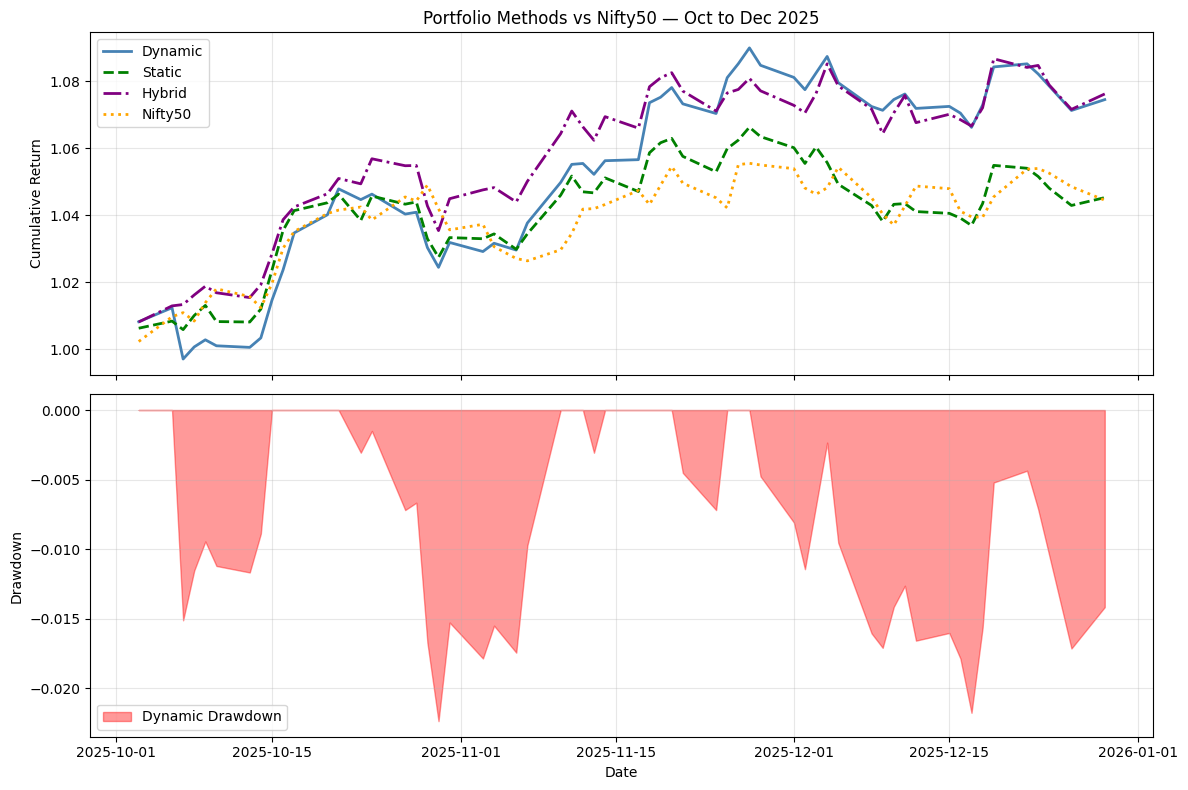

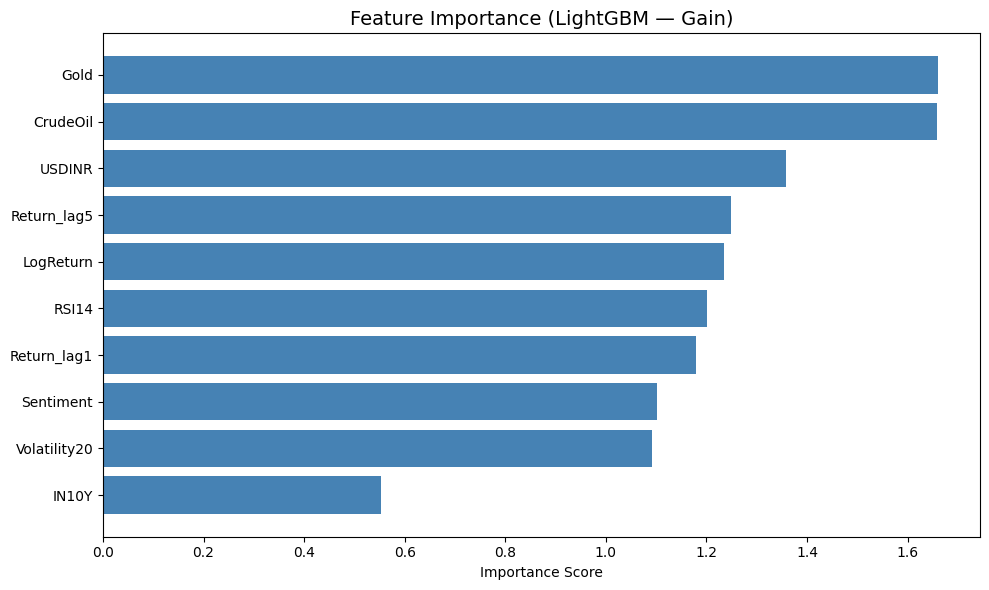

Saved equity_curve.png and feature_importance.png


In [38]:
# ── Equity Curve — All Methods vs Nifty50 ────────────────────────────
port_cum_aligned    = (1 + port_aligned).cumprod()
nifty_cum_aligned   = (1 + nifty_aligned).cumprod()
cum_static_aligned  = (1 + portfolio_returns_static.loc[common_dates]).cumprod()
cum_hybrid_aligned  = (1 + portfolio_returns_hybrid.loc[common_dates]).cumprod()
drawdown_aligned    = (port_cum_aligned - port_cum_aligned.cummax()) / port_cum_aligned.cummax()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(port_cum_aligned.index,   port_cum_aligned.values,   label="Dynamic",  linewidth=2, color="steelblue")
ax1.plot(cum_static_aligned.index, cum_static_aligned.values, label="Static",   linewidth=2, color="green",  linestyle="--")
ax1.plot(cum_hybrid_aligned.index, cum_hybrid_aligned.values, label="Hybrid",   linewidth=2, color="purple", linestyle="-.")
ax1.plot(nifty_cum_aligned.index,  nifty_cum_aligned.values,  label="Nifty50",  linewidth=2, color="orange", linestyle=":")
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Portfolio Methods vs Nifty50 — Oct to Dec 2025")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.fill_between(drawdown_aligned.index, drawdown_aligned.values, 0, color="red", alpha=0.4, label="Dynamic Drawdown")
ax2.set_ylabel("Drawdown")
ax2.set_xlabel("Date")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("equity_curve.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Feature Importance ────────────────────────────────────────────────
importance    = final_model.feature_importance(importance_type="gain")
importance_df = pd.DataFrame({
    "Feature"   : selected_features,
    "Importance": importance
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="steelblue")
plt.title("Feature Importance (LightGBM — Gain)", fontsize=14)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved equity_curve.png and feature_importance.png")

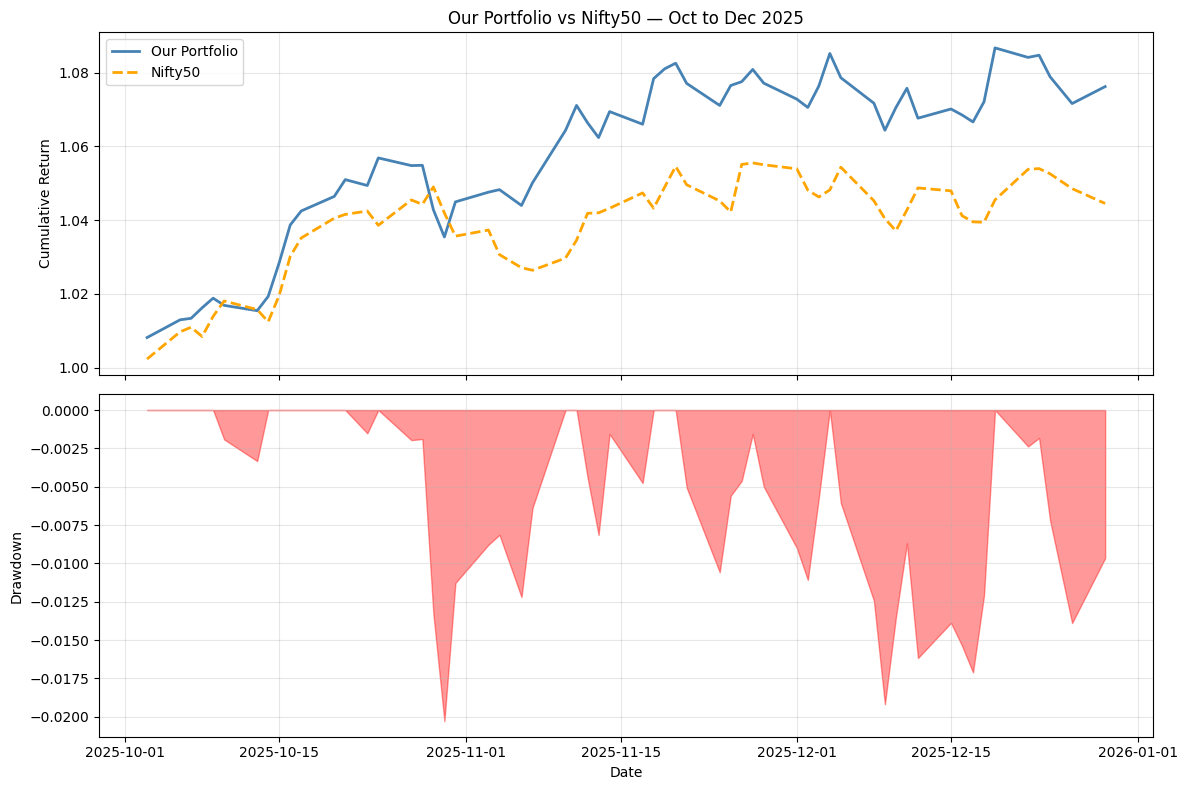

Saved equity_curve.png


In [40]:
# ── Equity Curve: Our Portfolio vs Nifty50 ────────────────────────────
cum_hybrid_aligned  = (1 + portfolio_returns_hybrid.loc[common_dates]).cumprod()
nifty_cum_aligned   = (1 + nifty_aligned).cumprod()
drawdown_hybrid     = (cum_hybrid_aligned - cum_hybrid_aligned.cummax()) / cum_hybrid_aligned.cummax()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(cum_hybrid_aligned.index, cum_hybrid_aligned.values, label="Our Portfolio", linewidth=2, color="steelblue")
ax1.plot(nifty_cum_aligned.index,  nifty_cum_aligned.values,  label="Nifty50",       linewidth=2, color="orange", linestyle="--")
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Our Portfolio vs Nifty50 — Oct to Dec 2025")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.fill_between(drawdown_hybrid.index, drawdown_hybrid.values, 0, color="red", alpha=0.4)
ax2.set_ylabel("Drawdown")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("equity_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved equity_curve.png")